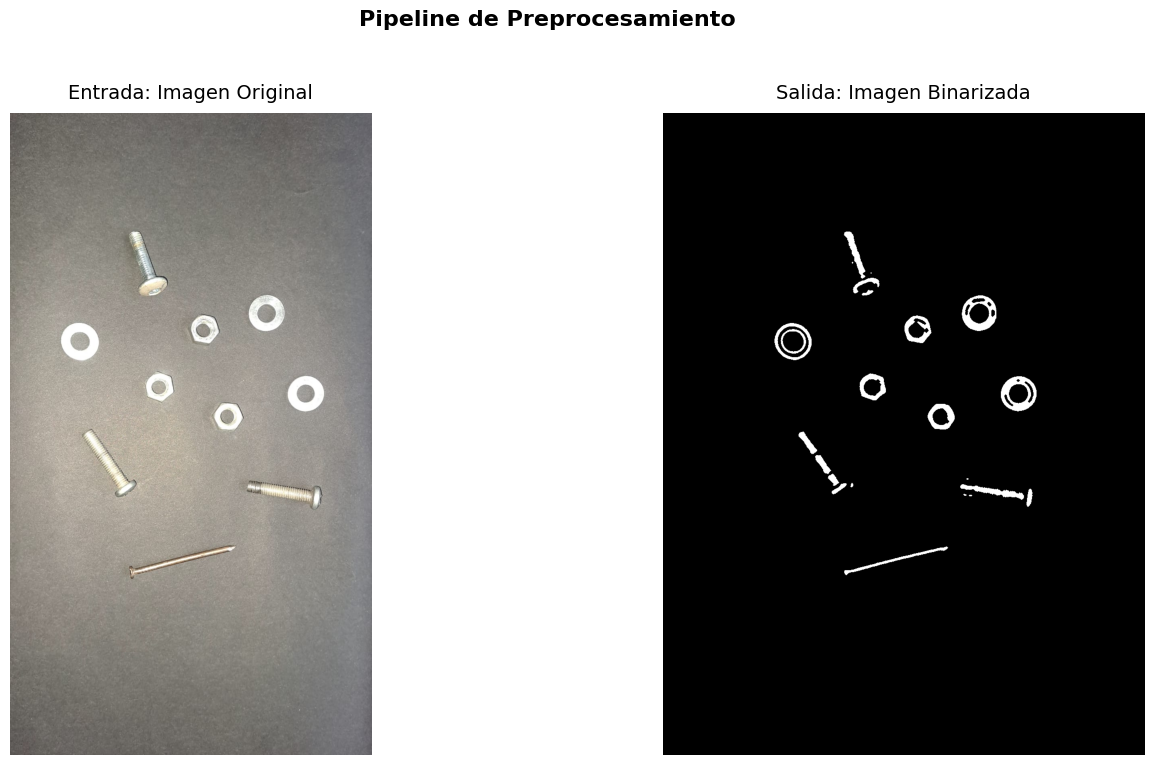

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import random
import numpy as np
import matplotlib.image as mpimg
from pathlib import Path
import logging
import cv2

# Agrego path de root
ROOT_PATH = str(Path.cwd().parent.parent)
if ROOT_PATH not in sys.path:
    sys.path.append(ROOT_PATH)

# Path de las imagenes
IMG_DATA_PATH = Path(ROOT_PATH + "/data/raw/images/all")
TEST_IMG_PATH = Path(ROOT_PATH + "/data/raw/images/tests")

from src.vision.preprocessor import ImagePreprocessor
from src.vision.segmentator import Segmentator
from src.vision.features import FeatureExtractor

# CONFIGURACIÓN
# Asegúrate de que ROOT_PATH esté definido previamente
TEST_IMG_PATH = Path(ROOT_PATH + "/data/raw/images/tests")
seed = 13

# 1. Obtener imagen aleatoria
images_files = list(TEST_IMG_PATH.glob("*.jpg")) + list(TEST_IMG_PATH.glob("*.jpeg")) + \
               list(TEST_IMG_PATH.glob("*.JPG")) + list(TEST_IMG_PATH.glob("*.JPEG"))

rng = random.Random(seed) if seed is not None else random
random_img_path = rng.choice(images_files)

# Cargar imagen original
img_original = mpimg.imread(random_img_path)

# 2. Procesar imagen
preprocessor = ImagePreprocessor(target_size = (960,1280),
                            gamma = 1.7,
                            d_bFilter = 8,
                            binarization_block_size = 27,
                            binarization_C = -5,
                            open_kernel_size = (3, 3),
                            close_kernel_size = (3, 3),
                            clear_border_margin = 3)

img_binary = preprocessor.process(img_original)

# 3. PLOT VISUALMENTE ATRACTIVO
# Creamos una figura con 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8)) # Tamaño ancho y alto para buena resolución

# -- Panel Izquierdo: Original --
ax1.imshow(img_original)
ax1.set_title("Entrada: Imagen Original", fontsize=14, pad=10)
ax1.axis('off') # Ocultamos los ejes para limpieza visual

# -- Panel Derecho: Binarizada --
# Usamos cmap='gray' para asegurar que el blanco/negro se vea correcto
ax2.imshow(img_binary, cmap='gray') 
ax2.set_title("Salida: Imagen Binarizada", fontsize=14, pad=10)
ax2.axis('off')

# -- Título General --
fig.suptitle(f"Pipeline de Preprocesamiento", 
             fontsize=16, fontweight='bold', y=0.95)

# Ajustar márgenes para que no quede espacio blanco innecesario
plt.tight_layout(rect=[0, 0, 1, 0.92]) # Dejamos espacio arriba para el suptitle
plt.show()

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_segmentation_report_final(img_path, preprocessor, segmentator):
    """
    Genera el plot final para el informe.
    Comparativa: Binaria Limpia vs. Binaria Anotada.
    Estilo: Layout estándar, BBox Rojo, Máscara Azul Oscuro.
    """
    
    # 1. Cargar y Procesar
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"❌ Error al cargar: {img_path}")
        return

    # A. Generar Binaria (Entrada del Segmentador)
    binary_img = preprocessor.process(img_bgr)
    
    # B. Ejecutar Segmentación
    seg_result = segmentator.process(binary_img)
    bboxes = seg_result.get("bounding_boxes", [])
    masks = seg_result.get("masks", [])

    # 2. Preparar Imagen para Visualización (Derecha)
    # Convertimos de Grises a RGB para poder pintar colores
    vis_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2RGB)
    
    # Definición de Colores (RGB)
    COLOR_BBOX = (255, 0, 0)      # Rojo Intenso
    COLOR_MASK = (0, 0, 180)      # Azul Oscuro
    
    # 3. Dibujar Anotaciones
    for i, (bbox, mask) in enumerate(zip(bboxes, masks)):
        x, y, w, h = bbox
        
        # A. DIBUJAR MÁSCARA
        if mask is not None:
            # Crear capa de color sólido
            colored_overlay = np.zeros_like(vis_img)
            colored_overlay[mask > 0] = COLOR_MASK
            
            # Mezclar para dar efecto de tintado
            # Donde hay máscara, mezclamos el blanco del objeto con el azul oscuro
            mask_indices = mask > 0
            vis_img[mask_indices] = cv2.addWeighted(
                vis_img[mask_indices], 0.6,  # 60% del color original (blanco)
                colored_overlay[mask_indices], 0.4, 0 # 40% del color azul
            )
            
            # Dibujar contorno para definir bien la forma
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img, contours, -1, COLOR_MASK, 2)

        # B. DIBUJAR BBOX
        cv2.rectangle(vis_img, (x, y), (x + w, y + h), COLOR_BBOX, 3)
        
        # C. ETIQUETA NUMÉRICA
        label = f"#{i+1}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        
        # Fondo rojo para el texto
        cv2.rectangle(vis_img, (x, y - 25), (x + tw + 4, y), COLOR_BBOX, -1)
        # Texto blanco
        cv2.putText(vis_img, label, (x + 2, y - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # 4. Configuración del Plot (Estándar)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8)) # Tamaño amplio y cómodo
    fig.suptitle(f"Segmentación", fontsize=16, fontweight='bold')

    # --- IZQUIERDA: Entrada ---
    ax1.imshow(binary_img, cmap='gray')
    ax1.set_title("Entrada (Máscara Binaria)", fontsize=14)
    ax1.axis('off')

    # --- DERECHA: Salida ---
    ax2.imshow(vis_img)
    ax2.set_title("Salida (Detección de Instancias)", fontsize=14)
    ax2.axis('off')

    # Ajuste de layout estándar (sin gridspec forzado)
    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    plt.show()

🖼️ Generando reporte visual para: 10_pieces_flash.jpeg


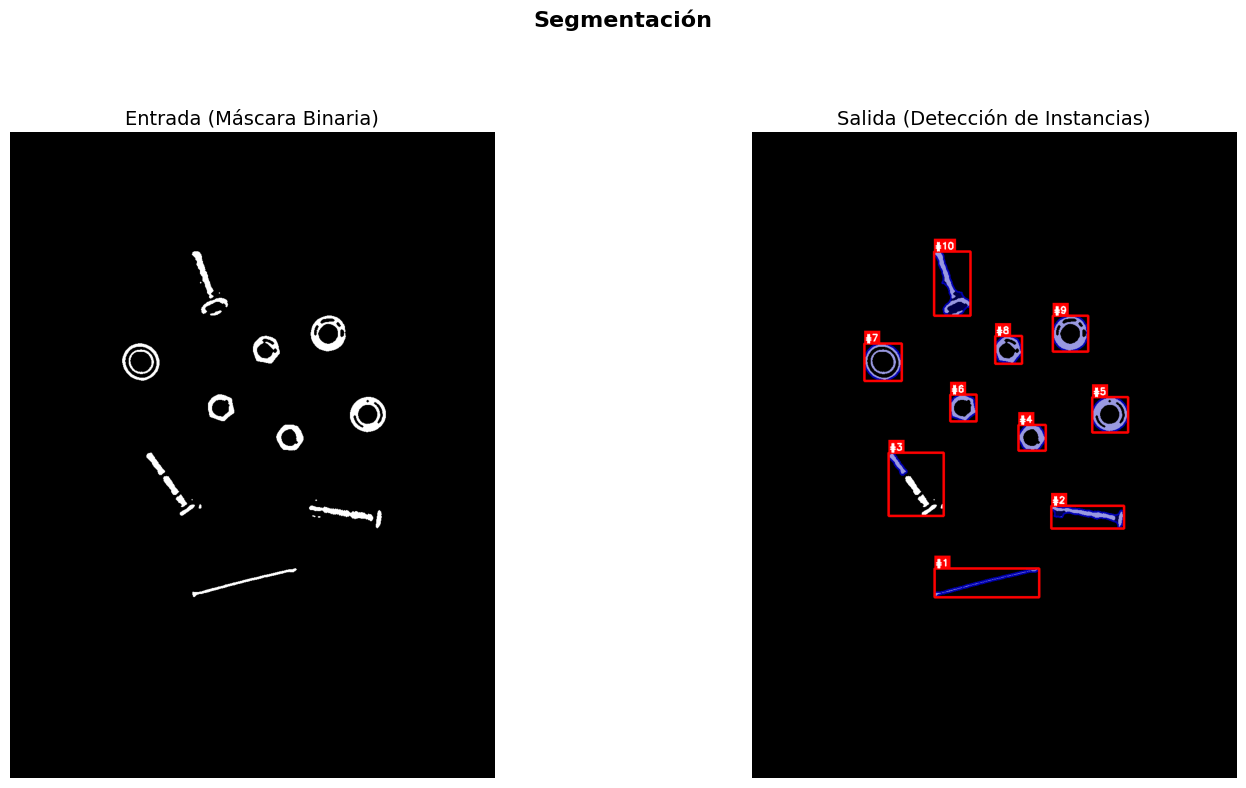

In [ ]:
# --- EJECUCIÓN ---

# 1. Instanciar Pipeline con tu configuración exacta
prep = ImagePreprocessor(target_size = (960,1280),
                            gamma = 1.7,
                            d_bFilter = 8,
                            binarization_block_size = 29,
                            binarization_C = -5,
                            open_kernel_size = (3, 3),
                            close_kernel_size = (3, 3),
                            clear_border_margin = 3)

seg = Segmentator(min_area = 10, merge_distance = 20)

# 2. Ejecutar visualización (usando la imagen aleatoria definida anteriormente)
print(f"🖼️ Generando reporte visual para: {random_img_path.name}")
visualize_segmentation_report_final(random_img_path, prep, seg)

📊 Generando tablas de datos para: 10_pieces_flash.jpeg


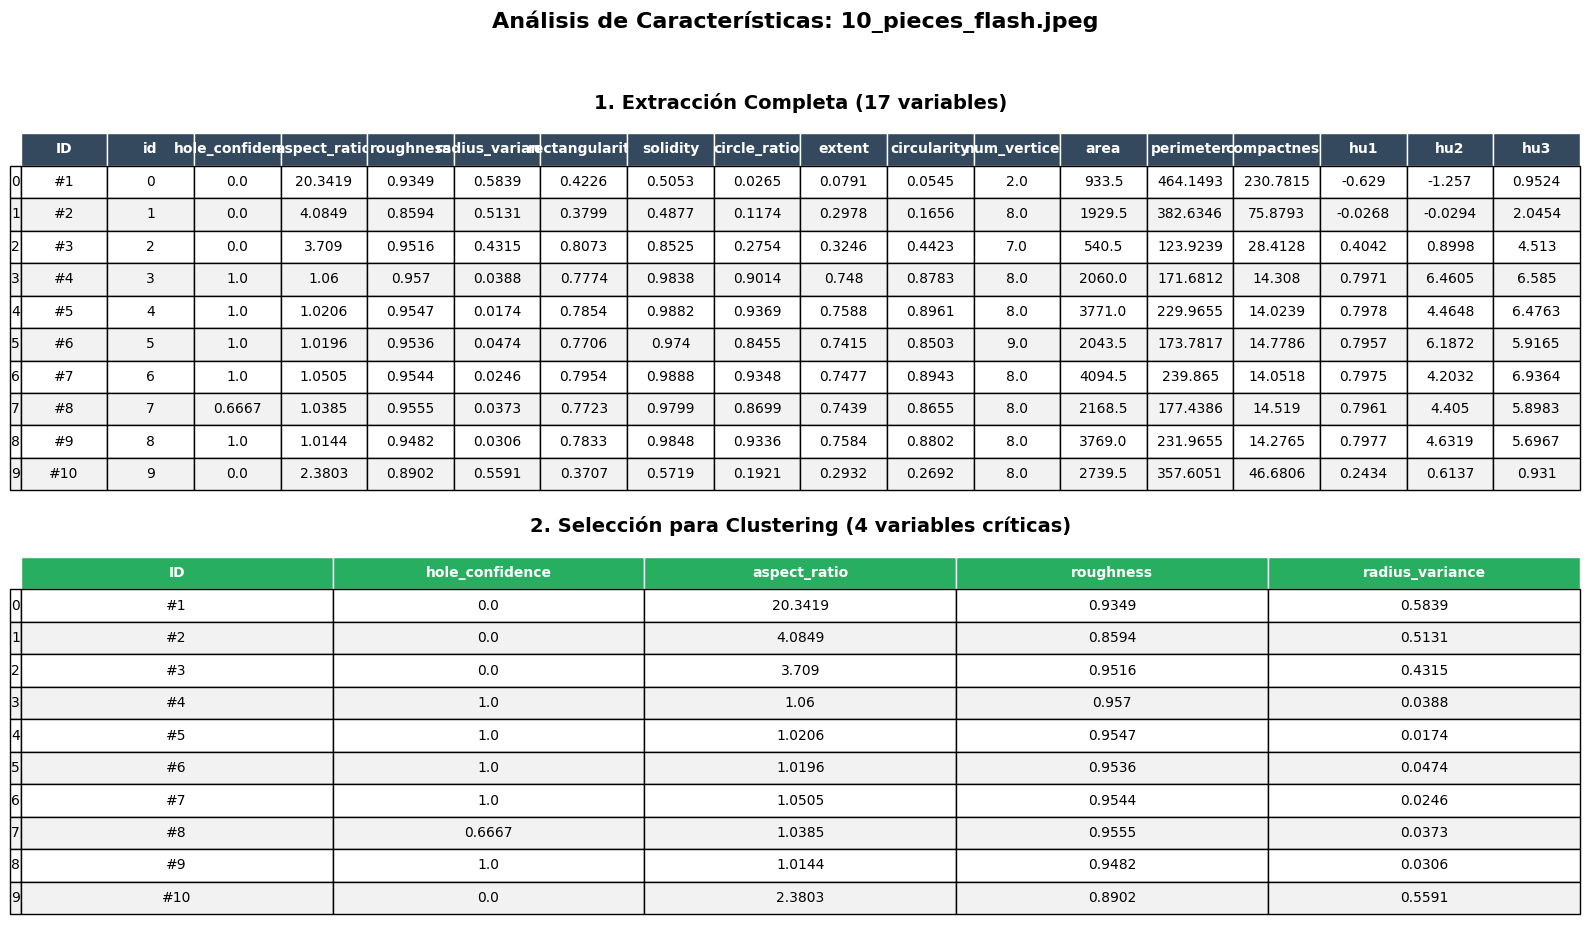

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table as pd_table

def visualize_feature_tables_only(img_path, preprocessor, segmentator, feature_extractor):
    """
    Genera un reporte tabular en dos filas:
    1. Tabla con TODAS las características extraídas (Raw).
    2. Tabla solo con las características seleccionadas para el modelo (K-Means).
    """
    
    # --- 1. EJECUCIÓN DEL PIPELINE ---
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"❌ Error al cargar: {img_path}")
        return
    
    # Procesamiento interno
    binary_img = preprocessor.process(img_bgr)
    seg_result = segmentator.process(binary_img)
    features_list = feature_extractor.extract_features(
        seg_result.get("bounding_boxes", []), 
        seg_result.get("masks", [])
    )

    if not features_list:
        print("⚠️ No se detectaron objetos para extraer características.")
        return

    # --- 2. PREPARACIÓN DE DATOS (Pandas) ---
    df = pd.DataFrame(features_list)
    
    # Añadir columna ID al principio
    df.insert(0, 'ID', [f"#{i+1}" for i in range(len(df))])

    # A. TABLA 1: TODAS LAS CARACTERÍSTICAS
    # Eliminamos solo lo que no es dato numérico/texto (objetos python)
    cols_to_drop = ['bbox', 'mask', 'contour'] 
    df_all = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    df_all = df_all.round(4) # Redondeo limpio

    # B. TABLA 2: SELECCIÓN PARA K-MEANS
    # Obtenemos las columnas recomendadas desde la clase FeatureExtractor
    target_cols = feature_extractor.get_recommended_features()
    
    # Filtramos el DataFrame, manteniendo la columna ID para referencia
    cols_kmeans = ['ID'] + target_cols
    # Aseguramos que existan las columnas (intersección) para evitar errores
    valid_cols = [c for c in cols_kmeans if c in df.columns]
    df_kmeans = df[valid_cols].round(4)


    # --- 3. GRAFICAR TABLAS ---
    # Creamos figura con 2 filas
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle(f"Análisis de Características: {img_path.name}", 
                 fontsize=16, fontweight='bold', y=0.98)

    # Función auxiliar para estilar tablas
    def render_styled_table(ax, dataframe, title, color_header='#2c3e50'):
        ax.axis('off')
        tbl = pd_table(ax, dataframe, loc='center', cellLoc='center')
        
        # Ajuste de fuente y tamaño
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(10)
        tbl.scale(1.0, 1.8) # (ancho, alto de celdas)
        
        # Estilo de Header
        for k, cell in tbl.get_celld().items():
            if k[0] == 0: # Fila 0 es el header
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor(color_header)
                cell.set_edgecolor('white')
            else:
                # Alternar color de filas para legibilidad (Zebra striping)
                if k[0] % 2 == 0:
                    cell.set_facecolor('#f2f2f2')

        ax.set_title(title, fontsize=14, weight='bold', pad=10)

    # Renderizar Tabla 1 (Todas)
    render_styled_table(ax1, df_all, 
                        f"1. Extracción Completa ({len(df_all.columns)-1} variables)", 
                        color_header='#34495e') # Gris azulado

    # Renderizar Tabla 2 (K-Means)
    render_styled_table(ax2, df_kmeans, 
                        f"2. Selección para Clustering ({len(target_cols)} variables críticas)", 
                        color_header='#27ae60') # Verde (Significa "Datos listos")

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# --- EJECUCIÓN ---
feat_extractor = FeatureExtractor()
print(f"📊 Generando tablas de datos para: {random_img_path.name}")
visualize_feature_tables_only(random_img_path, prep, seg, feat_extractor)